# jupyter notebook related to __[coursera ML course](https://www.coursera.org/learn/machine-learning/)__

The course uses MATLAB, and so the main task here is
translating the MATLAB code for the various functions
(in this case neural network learning) to a python
version.

I'm adding a new version of the notebook for every
week, as a convenience for myself to see the progress,
rather than having to go through the history on github.

### Settings (put at the top for ease of changing)

In [1]:
# network configuration
layer1 = [25, 401]
layer2 = [10, 26]
layers = (layer1, layer2)

# regularization
reglambda = 0.1

# stopping criterion
stop_crit = 1.0e-8

In [2]:
# data from binary files
import numpy as np
X = (1.0 / 255.0) * np.fromfile('mnist_5000_20_20.bin', dtype=np.uint8, count=5000*20*20).reshape((5000, 400), order='F').astype(np.float64)
y = np.fromfile('mnist_5000_20_20_lab.bin', dtype=np.uint8, count=5000) - 1
Y = np.zeros([y.size, 10])
for c in range(10):
    Y[y==c, c] = 1.0

Reusing the gradient descent function

In [3]:
# gradient descent for a cost-function
import math
def gradient_desc(fun, theta, *args, learning_rate = 0.1, maxiter = 500):
    """
    """
    # create theta_copy
    theta_copy = theta.copy()
    
    # compute initial cost, and figure out if gradients
    # are returned as well
    fun_with_grads = False
    cost0 = fun(theta, *args)
    if type(cost0) == tuple:
        fun_with_grads = True
        theta_grads = cost0[1]
        cost0 = cost0[0]
    else:
        theta_grads = pgrads_of_fun_for_theta(fun, theta_copy, *args)
    
    # values over time
    cost_vals = np.empty((maxiter, 1))
    cost_vals[:] = np.nan
    
    # iterate
    iter = 0;
    while iter < maxiter:
        
        # store values
        cost_vals[iter] = cost0

        # update theta based on learning rate
        theta_copy = theta_copy - learning_rate * theta_grads
        
        # compute new cost
        if fun_with_grads:
            cost = fun(theta_copy, *args)
            theta_grads = cost[1]
            cost = cost[0]
        else:
            cost = fun(theta_copy, *args)
            theta_grads = pgrads_of_fun_for_theta(fun, theta_copy, *args)
        
        # if difference smaller criterion
        if math.fabs(cost0 - cost) < stop_crit:
            break
        
        # update cost
        cost0 = cost
        iter = iter + 1
    
    # store last value?
    if iter < maxiter:
        cost_vals[iter] = cost

    # return theta_copy and cost_vals
    return (theta_copy, cost_vals)

In [4]:
# sigmoid function
def sigmoid(z):
    return np.true_divide(1.0, 1.0 + np.exp(-z))

In [5]:
# define a cost function for the network
def networkcost(theta, X, Y, l, shapes):
    
    # copy out thetas
    thetas = []
    ti = 0
    for s in shapes:
        thetas.append(theta[ti:ti+np.prod(s)].reshape(s, order='F'))
        ti += np.prod(s)
    
    # transpose Y if necessary
    if thetas[-1].shape[0] == Y.shape[1]:
        Y = Y.T
    
    # number of samples
    m = Y.shape[1]
    
    # prepare arrays
    Xt = []
    d = [None] * (len(thetas)+1)
    grads = [None] * (len(thetas))
    
    # transpose X if necessary
    if X.shape[0] == m:
        Xt.append(X.T)
    else:
        Xt.append(X)
    
    # sum over theta squared
    tss = 0.0
    
    # forward prop
    for tc in range(len(thetas)):
        
        # add bias units
        if Xt[tc].shape[0] < thetas[tc].shape[1]:
            Xt[tc] = np.concatenate((np.ones((1, Xt[tc].shape[1])), Xt[tc]))
        Xt.append(sigmoid(np.matmul(thetas[tc], Xt[tc])))
        
        # square theta
        tsq = np.multiply(thetas[tc], thetas[tc])
        tss += l * np.sum(tsq[:,1:])
    
    # output layer
    p = Xt[-1]
    
    # sanity replacements
    p[p==0] = 2.3e-16
    p[p==1] = 1.0 - 2.3e16
    
    # first delta
    d[len(thetas)] = p - Y
    
    # cost
    mm = (1.0 / m)
    J = (-mm) * np.sum(np.multiply(Y, np.log(p)) + np.multiply(1.0 - Y, np.log(1.0 - p))) + (0.5 / m) * tss
    
    # backprop
    for tc in range(len(thetas)-1, -1, -1):
        if tc > 0:
            Xi = np.multiply(Xt[tc], 1.0 - Xt[tc])
            d[tc] = np.multiply(np.matmul(thetas[tc][:,1:].T, d[tc+1]), Xi[1:,:])
        g = mm * np.matmul(d[tc+1], Xt[tc].T)
        lm = (mm * l) * np.ones(thetas[tc].shape)
        lm[:, 0] = 0.0
        if g.shape[0] == thetas[tc].shape[0]:
            grads[tc] = g + np.multiply(lm, thetas[tc])
        else:
            grads[tc] = g[1:, :] + np.multiply(lm, thetas[tc])
    
    # packing gradients
    ti = 0
    gc = 0
    grad = np.zeros(theta.size)
    for s in shapes:
        tnum = np.prod(s)
        grad[ti:ti+tnum] = grads[gc].reshape(tnum, order='F')
        ti += tnum
        gc += 1
    
    # formalize prediction (from values to class choice)
    p = np.argmax(p, 0).reshape(m)
    
    # return outputs
    return J, grad, p

In [7]:
# random theta
np.random.seed(0)
theta = 0.5 - np.random.rand(np.prod(layer1) + np.prod(layer2))

In [8]:
# initial cost
J, g, p = networkcost(theta, X, Y, reglambda, layers)
J

8.682273156349645

In [9]:
# run 25000 iterations gradient descent
(theta, cost_v) = gradient_desc(networkcost, theta, X, Y, reglambda, layers, learning_rate = 0.01, maxiter = 25000)

In [10]:
# new cost
J, g, p = networkcost(theta, X, Y, reglambda, layers)
J

0.6825470331837984

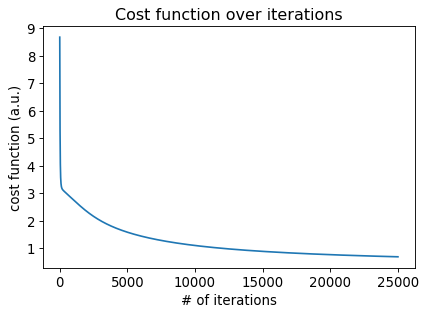

In [12]:
# plot cost over time
import matplotlib.pyplot as plt

# set some plotting parameters (font size)
plt.rcParams.update({'font.size': 12})

# start a figure
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(cost_v)
plt.title('Cost function over iterations')
plt.xlabel('# of iterations')
plt.ylabel('cost function (a.u.)')
plt.show()

In [14]:
# accuracy (training set!, not cross-validation!)
np.sum(p==y) / len(p)

0.9144